In [116]:
import pickle
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib import colors
import torch
from scipy.stats import entropy
import sparse
from scipy.special import logsumexp

import composlang
from composlang.utils import minmax, JointDist

In [2]:
comp = pd.read_pickle("./comp.pkl")

In [3]:
[k for k in dir(comp) if k[0] != "_"]

['bipartite_layout',
 'child_df',
 'child_upos',
 'compute_combinations',
 'compute_entropy',
 'compute_pmi',
 'generate_adjacency_matrix',
 'generate_combinations',
 'inspect_neighborhood',
 'matrix',
 'n_tokens',
 'pair_df',
 'pair_stats',
 'parent_df',
 'parent_upos',
 'read_csv',
 'run_analyses',
 'sample_combinations',
 'to_csv',
 'token_stats']

In [4]:
comp.n_tokens

592974127

In [5]:
comp.pair_df.freq.sum()

25178311

In [7]:
adj_ids = np.arange(len(comp.child_df))
adj_ps = comp.child_df.freq
noun_ids = np.arange(len(comp.parent_df))
noun_ps = comp.parent_df.freq
m = comp.pair_df.freq.sum()
print(f"{m:,}")

25,178,311


In [8]:
num_unique_pairs = []
for _ in tqdm([*range(100)]):
    unique_pairs = set()
    batch_size = 2**16
    total_draws = 0
    for i in [*range(0, m, batch_size)]:
        sample_size = min(batch_size, m - i)
        total_draws += sample_size
        adj_ids_choice = np.random.choice(
            adj_ids, sample_size, p=adj_ps / adj_ps.sum(), replace=True
        )
        noun_ids_choice = np.random.choice(
            noun_ids, sample_size, p=noun_ps / noun_ps.sum(), replace=True
        )
        unique_pairs.update(set(zip(adj_ids_choice, noun_ids_choice)))

    print(len(unique_pairs))
    num_unique_pairs += [len(unique_pairs)]

  0%|          | 0/100 [00:00<?, ?it/s]

8979778
8979051
8977732
8978918
8976379
8974431
8976425
8973869
8976156
8975202
8977811
8977873
8976793
8976327
8975294
8972865
8977452
8975151
8976578
8975574
8974641
8976676
8975262
8971158
8972193
8978237
8978441
8976288
8975159
8976848
8976972
8978151
8976200
8977178
8975128
8974848
8977366
8979224
8976248
8978015
8973662
8976308
8973322
8976649
8975528
8975799
8974832
8972782
8976380
8975973
8979680
8978766
8979510
8973775
8975730
8976851
8975063
8977025
8977187
8979036
8977550
8977209
8975322
8976437
8975240
8976219
8978026
8977438
8975390
8976662
8977710
8975936
8976185
8975966
8974742
8976596
8978421
8974021
8974186
8976019
8979559
8974943
8975407
8978354
8978636
8979451
8974824
8975200
8976245
8976151
8976101
8974204
8976526
8975077
8977431
8978655
8973390
8974718
8976235
8974580


In [9]:
num_unique_pairs = np.array(num_unique_pairs)
print(num_unique_pairs.mean(), num_unique_pairs.std())

8976287.12 1750.9518513083106


In [ ]:
# comp_simulated = pd.read_pickle("./comp.pkl")
# comp_simulated.pair_df = pair_df_simulated
# mat_simulated = comp_simulated.generate_adjacency_matrix(threshold=0)
# with open("./mat_simulated.pkl", "wb") as f:
#     pickle.dump(mat_simulated, f)

In [ ]:
# f"{len(comp_observed.child_df) :,}         {len(comp_observed.parent_df):,}"
"147,047         469,833"

# f"{len(comp_observed.child_df) * len(comp_observed.parent_df):,}"
"69,087,533,151"

4423676 / 69087533151 * 100
0.006403001812688067

'147,047         469,833'

In [117]:
mat_simulated = pd.read_pickle("./mat_simulated.pkl")
mat_observed = pd.read_pickle("./matrix.pkl")

```python
comp_observed.pair_df
```
![](https://i.imgur.com/4tDU93j.png)

```
pair_df_simulated.sort_values(by="freq", ascending=False)
```
![](https://i.imgur.com/djuMtj4.png)`

In [ ]:
# f"{len(pair_df_simulated):,}"  # b
# '8,977,777'
# f'{sum(pair_df_simulated["freq"]):,}'  # N
# '25,178,311'

'8,977,777'

In [118]:
obs = mat_observed[:1000, :1000].todense()
sim = mat_simulated[:1000, :1000].todense()
max_value = max(
    max(obs.reshape(-1)),
    max(sim.reshape(-1)),
)
max_value

63780

In [121]:
f"{obs.sum():,}"

'11,763,491'

In [110]:
def plot_matrix(mat, title=None, vmin=None, vmax=None, lognorm=False):
    f, ax = plt.subplots(figsize=(7, 7))
    im = ax.matshow(
        mat,
        aspect="equal",
        interpolation="none",
        origin="lower",
        cmap="Reds",
        norm=LogNorm(vmin=vmin, vmax=vmax) if lognorm else None,
    )
    # add axis labels
    ax.set_xlabel("Adjectives")
    ax.set_ylabel("Nouns")
    ax.set_title(title)
    # move xticks to lower part
    ax.xaxis.tick_bottom()
    f.colorbar(im)

    plt.show()

    return f, ax

In [39]:
obs_norm = minmax(obs)
sim_norm = minmax(sim)

In [111]:
plot_matrix(
    obs_norm,
    vmin=1e-5,
    title="COCA",
)

NameError: name 'obs_norm' is not defined

In [112]:
plot_matrix(
    sim_norm,
    vmin=1e-5,
    title="MaxComb",
)

NameError: name 'sim_norm' is not defined

In [3]:
mat_mpt30b = pd.read_pickle("./mat_mpt30b.pkl")
# mat_mpt30b_hybrid = pd.read_pickle("./mat_mpt30b_hybrid.pkl")
# mat_mpt30b_bayes = pd.read_pickle("./mat_mpt30b_bayes.pkl")

In [44]:
# mat_mpt30b_norm = minmax(np.exp(mat_mpt30b))
# mat_mpt30b_hybrid_norm = minmax(np.exp(mat_mpt30b_hybrid))
# mat_mpt30b_bayes_norm = minmax(np.exp(mat_mpt30b_bayes))

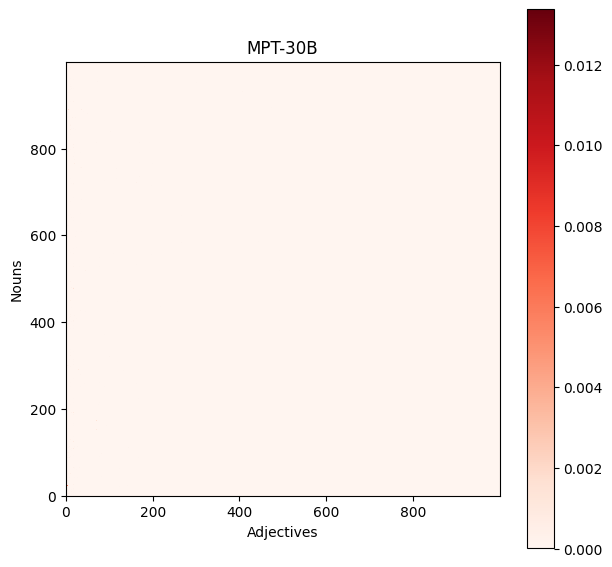

(<Figure size 700x700 with 2 Axes>,
 <AxesSubplot:title={'center':'MPT-30B'}, xlabel='Adjectives', ylabel='Nouns'>)

In [114]:
plot_matrix(
    np.exp(mat_mpt30b_hybrid_norm),
    # vmax=10e-2,
    vmin=1e-5,
    title="MPT-30B",
)

## Joint entropy

In [18]:
joint = pd.read_pickle("./joint1000.pkl")
cond = joint.conditionalize(axis=0)

In [29]:
logsumexp(joint.joint), logsumexp(cond.joint), logsumexp(mat_mpt30b)

(0.0, 1.0337832355134364, 5.561775927755333)

In [64]:
cond.joint = mat_mpt30b  # let's plug in the conditional distribution from MPT-30B
cond = cond.conditionalize(axis=0)  # normalize the conditionals to make them proper
cond.joint += joint.get_marginal_of_axis(0)[
    :, None
]  # multiple COCA adjective marginals to conditionals
cond.joint -= logsumexp(cond.joint)  # normalize the joint distribution
logsumexp(cond.joint), logsumexp(joint.joint)

(0.0, 0.0)

In [88]:
sim = joint.conditionalize(
    axis=0
)  # literally just to make a copy. i'm going to replace the matrix
sim.joint = np.add.outer(
    joint.get_marginal_of_axis(0),
    joint.get_marginal_of_axis(1),
)
sim.joint -= logsumexp(sim.joint.reshape(-1))
logsumexp(sim.joint)

0.0

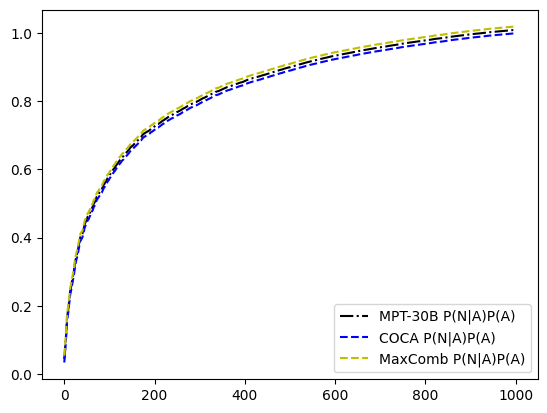

In [89]:
plt.plot(
    np.cumsum(np.exp(cond.get_marginal_of_axis(0))) + 0.01,
    "k-.",
    label="MPT-30B P(N|A)P(A)",
)
plt.plot(
    np.cumsum(np.exp(joint.get_marginal_of_axis(0))), "b--", label="COCA P(N|A)P(A)"
)
plt.plot(
    np.cumsum(np.exp(joint.get_marginal_of_axis(0))) + 0.02,
    "y--",
    label="MaxComb P(N|A)P(A)",
)
plt.legend()
plt.show()

In [102]:
# E_X = entropy(adj_freqs)
# E_Y = entropy(noun_freqs)


def compute_entropy(mat, kind, sparse=False):
    E_X = entropy(mat.sum(axis=1))
    E_Y = entropy(mat.sum(axis=0))

    E_X_Y = entropy(mat.reshape(-1))
    I_X_Y = E_X + E_Y - E_X_Y

    print(
        f"E_X_{kind}: {E_X:.3f}, E_Y_{kind}: {E_Y:.3f}, E_X_Y_{kind}: {E_X_Y:.3f}",
        "\n",
        f"I_X_Y_{kind} = E_X + E_Y - E_X_Y: {I_X_Y:.3f}\n",
    )
    return E_X, E_Y, E_X_Y, I_X_Y

In [103]:
entropies = []

In [104]:
ex, ey, exy, ixy = compute_entropy(np.exp(joint.joint), "observed", sparse=True)
entropies.append(
    {
        "kind": "COCA",
        "E_X": ex,
        "E_Y": ey,
        "E_X_Y": exy,
        "I_X_Y": ixy,
    }
)

E_X_observed: 5.875, E_Y_observed: 6.421, E_X_Y_observed: 10.624 
 I_X_Y_observed = E_X + E_Y - E_X_Y: 1.672



In [105]:
ex, ey, exy, ixy = compute_entropy(
    np.exp(sim.joint),
    "simulated",
)
entropies.append(
    {
        "kind": "MaxComb",
        "E_X": ex,
        "E_Y": ey,
        "E_X_Y": exy,
        "I_X_Y": ixy,
    }
)

E_X_simulated: 5.875, E_Y_simulated: 6.421, E_X_Y_simulated: 12.296 
 I_X_Y_simulated = E_X + E_Y - E_X_Y: 0.000



In [106]:
ex, ey, exy, ixy = compute_entropy(np.exp(cond.joint), "MPT")
entropies.append(
    {
        "kind": "MPT-30B",
        "E_X": ex,
        "E_Y": ey,
        "E_X_Y": exy,
        "I_X_Y": ixy,
    }
)

E_X_MPT: 5.875, E_Y_MPT: 6.252, E_X_Y_MPT: 10.344 
 I_X_Y_MPT = E_X + E_Y - E_X_Y: 1.783



In [107]:
ent = pd.DataFrame(entropies)
ent

,kind,E_X,E_Y,E_X_Y,I_X_Y
0,COCA,5.875245,6.420858,10.623823,1.672280e+00
1,MaxComb,5.875245,6.420858,12.296103,3.552714e-15
2,MPT-30B,5.875245,6.251535,10.343513,1.783266e+00


In [108]:
print(ent.to_latex(float_format="%.3f", index=False))

\begin{tabular}{lrrrr}
\toprule
   kind &   E\_X &   E\_Y &  E\_X\_Y &  I\_X\_Y \\
\midrule
   COCA & 5.875 & 6.421 & 10.624 &  1.672 \\
MaxComb & 5.875 & 6.421 & 12.296 &  0.000 \\
MPT-30B & 5.875 & 6.252 & 10.344 &  1.783 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_190053/1249619511.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ent.to_latex(float_format="%.3f", index=False))


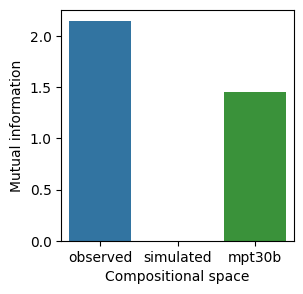

In [132]:
f, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data=ent,
    x="kind",
    y="I_X_Y",
)
ax.set_ylabel("Mutual information")
ax.set_xlabel("Compositional space")

plt.show()